**Initialization**
* I use these 3 lines of code on top of my each Notebooks because it will help to prevent any problems while reloading and reworking on a Project or Problem. And the third line of code helps to make visualization within the Notebook.

In [1]:
# Initialization
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Downloading the Dependencies**
* I have downloaded all the Libraries and Dependencies required for this Project in one particular cell.

In [29]:
# Downloading the Libraries and Dependencies.
# !pip install jupyterthemes
# !pip install nlpia


# Importing the Libraries and Dependencies.
import numpy as np
import pandas as pd
import nltk                                                                          # Library for Natural Language Processing.
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA                                                # PCA or SVD in Scikit Learn.
from sklearn.decomposition import TruncatedSVD                                       # Importing the Truncated SVD.
from nltk.tokenize.casual import casual_tokenize
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import LatentDirichletAllocation as LDiA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Dependencies for Visualization.
from jupyterthemes import jtplot
jtplot.style(theme = "monokai", context = "notebook", ticks = True, grid = False)

**Getting the Data**
* Here, I will be using NLPIA package to get the Dataset which contains Spam messages and Non Spam messages. And I will train LDA Model to classify whether the SMS messages are Spam or Non Spam.

In [12]:
# Importing the Dataset.
from nlpia.data.loaders import get_data                  # Loading the NLPIA Package.
sms = get_data("sms-spam")                               # Downloading the SMS messages.
cloud = get_data("pointcloud").sample(1000)

**Creating the DataFrame**
* I will create a DataFrame from the Dataset obtained above using NLPIA package. The Dataset contains SMS messages which are Spam Messages and Non Spam Messages. 

In [6]:
# Creating the DataFrame. 
index = ["sms{}{}".format(i, "!" * j) for (i,j) in zip(range(len(sms)), sms.spam)]
sms = pd.DataFrame(sms.values, columns=sms.columns, index=index)                     # Creating the SMS DataFrame.
sms["spam"] = sms.spam.astype(int)                                                   # Creating the Spam Column.

# Inspecting the DataFrame.
display(f"The Shape of DataFrame is {sms.shape}")                                    # Inspecting the shape of DataFrame.
display(sms.head(10))                                                                # Inspecting the first 10 Data of the DataFrame.

'The Shape of DataFrame is (4837, 2)'

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."
sms5!,1,FreeMsg Hey there darling it's been 3 week's n...
sms6,0,Even my brother is not like to speak with me. ...
sms7,0,As per your request 'Melle Melle (Oru Minnamin...
sms8!,1,WINNER!! As a valued network customer you have...
sms9!,1,Had your mobile 11 months or more? U R entitle...


* The DataFrame contains 4837 SMS messages. And the spam column in the DataFrame is labeled with 1 if the SMS messages are SPAM whereas the column is labeled with 0 if the SMS messages are Non Spam.

**Tokenization and TFIDF Vectorization**
* Now, The primary step in Text Processing is Tokenization and TFIDF Vectorization. In Natural Language Processing, String Tokenization is a process where the string is split into individual words or individual parts without blanks and tabs. Text Vectorization is the process of converting Text into Numerical representation.

In [7]:
# Tokenization and TFIDF Vectorizatio of the Text.
tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)                      # Creating Pipeline of Tokenization and Vectorization.
tfidf_docs = tfidf_model.fit_transform(raw_documents=sms.text).toarray()

# Inspecting the TFIDF results.
display(f"Shape is {tfidf_docs.shape}")                                       # Inspecting the shape of TFIDF.
display(f"Actual Spam messages is {sms.spam.sum()}")                          # Inspecting the spam messages in DataFrame.

'Shape is (4837, 9232)'

'Actual Spam messages is 638'

* Here, The Casual Tokenizer gives 9232 words in the Vocabulary. It's almost many words than the messages. It's 10 times many words than the Spam messages. Using a Naive Bayes Classifier won't work well when the Vocabulary is much larger than the number of labeled examples in the Dataset. So, Semantic Analysis Technique will help here.

**Linear Discriminant Analysis: LDA**
* LDA Model can be used in Scikit Learn easily using sklearn.discriminant_analysis.LinearDiscriminantAnalysis. But, I will compute the centroid of our binary Class i.e Spam or Non Spam Classes inorder to train the Model. Computing the centroid of TFIDF vectors for each side of the binary Class is the working Principal of LDA.

In [8]:
# Implementing the LDA Classifier.
mask = sms.spam.astype(bool).values                               # Creating the mask to select only the Spam rows.
spam_centroid = tfidf_docs[mask].mean(axis=0)                     # Calculating the mean of Spam messages.
ham_centroid = tfidf_docs[~mask].mean(axis=0)                     # Calculating the mean of Non spam meassages.

# Calculating the line between Spam and Non Spam centroids.
spaminess_score = tfidf_docs.dot(spam_centroid - ham_centroid)    # Dot product computes the Projection of each vectors of the line between centroids.
spaminess_score.round(2)                                          # Inspecting the Spaminess score.

array([-0.01, -0.02,  0.04, ..., -0.01, -0.  ,  0.  ])

* Now, I will manage the score in the range of 0 and 1 like in the Probability. The Scikit Learn MinMaxScaler is very useful in doing this process. 

In [9]:
# Inspecting the LDA Classifier result.
sms["lda_score"] = MinMaxScaler().fit_transform(spaminess_score.reshape(-1, 1))
sms["lda_predict"] = (sms.lda_score > 0.5).astype(int)
sms["spam lda_predict lda_score".split()].round(2).head(10)                          # Inspecting the Final Result.

,spam,lda_predict,lda_score
sms0,0,0,0.23
sms1,0,0,0.18
sms2!,1,1,0.72
sms3,0,0,0.18
sms4,0,0,0.29
sms5!,1,1,0.55
sms6,0,0,0.32
sms7,0,0,0.50
sms8!,1,1,0.89
sms9!,1,1,0.77


**Model Evaluation**
* Here, All of the 10 Messages are classified correctly when the threshold is 50%. Let's inspect how it did on rest of the Training set.


In [10]:
# Inspecting the Model Evaluation.
(1 - (sms.spam - sms.lda_predict).abs().sum() / len(sms)).round(3)

0.977

* Wow! 97.7% of the Messages are classified correctly with this simple LDA Model.

**PCA on 3D Vectors**

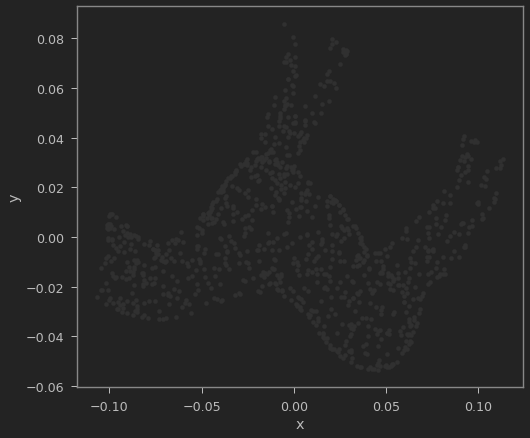

In [11]:
# PCA on 3D Vectors.
pca = PCA(n_components=2)                                             # Reducing 3D point cloud to 2D projection to display 2D Scatter Plot.
clouddf = pd.DataFrame(pca.fit_transform(cloud), columns=list("xy"))  # Creating the DataFrame.
clouddf.plot(kind="scatter", x="x", y="y")
plt.show()

**PCA on Semantic Analysis**
* I will be working on the same SMS Messages Dataset which contains Spam Messages and Non Spam Messages.

In [13]:
# Creating the DataFrame.
index = ["sms{}{}".format(i, "!" * j) for (i,j) in zip(range(len(sms)), sms.spam)]
sms = pd.DataFrame(sms.values, columns=sms.columns, index=index)  
sms["spam"] = sms.spam.astype(int)
display(sms.head(10))

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."
sms5!,1,FreeMsg Hey there darling it's been 3 week's n...
sms6,0,Even my brother is not like to speak with me. ...
sms7,0,As per your request 'Melle Melle (Oru Minnamin...
sms8!,1,WINNER!! As a valued network customer you have...
sms9!,1,Had your mobile 11 months or more? U R entitle...


* Now, I will calculate the TFIDF Vectors for each of these Messages.

In [14]:
# Tokenization and TFIDF Vectorizatio of the Text.
tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)                      # Creating Pipeline of Tokenization and Vectorization.
tfidf = tfidf_model.fit_transform(raw_documents=sms.text).toarray()
tfidf_docs = pd.DataFrame(tfidf)
tfidf_docs = tfidf_docs - tfidf_docs.mean()                                   # Centering the Vectorized Documents.

# Inspecting the TFIDF results.
display(f"Shape is {tfidf_docs.shape}")                                       # Inspecting the shape of TFIDF.
display(f"Actual Spam messages is {sms.spam.sum()}")                          # Inspecting the spam messages in DataFrame.

'Shape is (4837, 9232)'

'Actual Spam messages is 638'

* Here, The Casual Tokenizer gives 9232 words in the Vocabulary. It's almost many words than the messages. It's 10 times many words than the Spam messages. Using a Naive Bayes Classifier won't work well when the Vocabulary is much larger than the number of labeled examples in the Dataset. So, Semantic Analysis Technique will help here. So, it has many more unique words in the Vocabulary than the messages. It will result in Overfitting. Dimension Reduction is the primary countermeasure for overfitting. Latent Semantic Analysis **LSA** reduces the dimension and helps to prevent Overfitting. 

In [15]:
# Using PCA for SMS Message Semantic Analysis.
pca = PCA(n_components=16)                                                            # Reducing into 16D Projection.
pca = pca.fit(tfidf_docs)                                                             # Fitting the TFIDF Vectors.
pca_topic_vectors = pca.transform(tfidf_docs)

columns = ["topic{}".format(i) for i in range(pca.n_components)]
pca_topic_vectors = pd.DataFrame(pca_topic_vectors, columns=columns, index=index)

# Inspecting the DataFrame.
pca_topic_vectors.round(3).head(10)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.201,0.003,0.037,0.011,-0.019,-0.053,0.039,-0.066,0.012,-0.083,0.005,0.007,-0.019,-0.027,-0.015,0.031
sms1,0.404,-0.094,-0.078,0.051,0.100,0.047,0.023,0.066,0.023,-0.025,-0.006,-0.033,-0.050,-0.002,0.049,-0.050
sms2!,-0.030,-0.048,0.090,-0.067,0.091,-0.043,-0.000,-0.000,-0.056,0.049,0.121,-0.027,-0.033,-0.001,-0.037,0.021
sms3,0.329,-0.033,-0.035,-0.016,0.052,0.056,-0.166,-0.075,0.061,-0.107,0.022,-0.022,-0.092,-0.015,0.022,-0.066
sms4,0.002,0.031,0.038,0.034,-0.075,-0.093,-0.044,0.062,-0.045,0.029,0.029,0.012,-0.011,0.039,-0.089,-0.031
sms5!,-0.016,0.059,0.014,-0.006,0.122,-0.040,0.005,0.167,-0.022,0.063,0.042,-0.053,0.058,0.061,-0.007,0.045
sms6,-0.066,-0.099,-0.045,-0.030,-0.032,0.036,-0.020,-0.014,-0.015,-0.080,0.081,-0.021,0.119,0.025,-0.060,-0.096
sms7,-0.024,-0.022,0.053,-0.047,0.055,-0.049,0.040,-0.020,-0.023,0.050,0.007,0.132,0.046,0.064,-0.006,-0.078
sms8!,-0.145,-0.092,0.040,-0.016,0.274,-0.054,0.013,-0.006,0.144,0.049,-0.008,-0.048,-0.075,-0.043,-0.015,0.092
sms9!,-0.041,0.039,0.103,-0.062,0.158,-0.016,-0.058,0.013,-0.015,0.119,0.084,0.050,0.068,-0.024,0.212,-0.051


**Creating the DataFrame**
* I will calculate the Weights to find out how  much words they contain in each components. It is easy to use .components_ attribute to find the weights of any Scikit Learn Transformation.

In [16]:
column_nums, terms = zip(*sorted(zip(tfidf_model.vocabulary_.values(), tfidf_model.vocabulary_.keys())))

# Creating the DataFrame:
weights = pd.DataFrame(pca.components_, columns=terms,
                       index=["topic{}".format(i) for i in range(16)])

# Inspecting the Weights DataFrame.
weights.round(3).head(10)

,!,"""",#,#150,#5000,$,%,&,',(,),*,+,",",-,.,. .,. . .,. . . .,. . . . .,. ..,..,.. .,.. . . .,.. ... ...,...,... . . . .,/,0,00,00870405040,0089,01,0121 2025050,01223585236,01223585334,01256987,02,02/06,02/09,...,yup,yupz,z,zac,zaher's,zealand,zebra,zed,zeros,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,|,~,,,,,,¡,£,»,èn,é,ú1,ü,ü'll,–,—,‘,’,“,…,┾,〨ud,鈥
topic0,-0.071,0.008,-0.001,-0.000,-0.001,0.003,-0.000,-0.012,-0.007,-0.005,-0.005,0.006,-0.013,-0.058,-0.011,-0.375,0.002,0.001,0.000,0.000,0.000,0.083,0.000,-0.000,0.000,0.675,0.000,-0.029,-0.002,-0.0,-0.000,-0.000,-0.001,-0.000,-0.000,-0.000,-0.000,-0.0,-0.002,-0.001,...,0.049,0.002,-0.0,0.000,-0.001,-0.0,-0.000,-0.001,-0.001,0.001,0.000,0.000,-0.000,0.001,0.000,0.0,-0.001,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.047,-0.0,-0.0,0.002,-0.0,0.109,0.003,-0.000,-0.0,-0.004,-0.001,-0.001,-0.002,0.001,0.001,0.001
topic1,0.064,0.008,0.000,-0.000,-0.001,-0.001,-0.002,-0.016,-0.016,0.001,0.002,0.040,-0.007,0.121,-0.012,-0.565,-0.003,0.000,0.001,0.000,0.000,0.081,-0.000,-0.001,-0.000,-0.085,0.001,-0.028,-0.003,-0.0,0.000,-0.000,-0.000,-0.000,-0.000,-0.001,-0.000,-0.0,0.001,-0.000,...,-0.025,-0.000,-0.0,0.000,0.001,-0.0,-0.000,-0.001,-0.001,-0.000,0.000,0.000,-0.001,-0.000,0.000,0.0,-0.000,0.000,0.001,0.002,-0.000,0.001,0.001,-0.000,-0.039,-0.0,-0.0,-0.000,-0.0,0.006,0.002,0.001,-0.0,0.004,-0.001,-0.001,0.003,0.001,0.001,0.001
topic2,0.071,0.027,0.000,0.001,0.002,0.000,0.001,0.059,0.008,0.019,0.029,-0.014,0.024,0.265,0.033,-0.295,-0.002,-0.001,0.001,0.001,0.001,0.169,0.001,0.001,0.000,-0.270,0.001,0.048,0.001,-0.0,0.001,0.000,0.001,0.001,0.000,0.000,0.000,-0.0,0.003,0.002,...,-0.010,-0.000,-0.0,0.001,-0.001,-0.0,0.001,0.002,-0.001,-0.000,0.000,0.001,-0.000,-0.000,0.001,0.0,0.003,0.000,0.001,0.003,0.001,0.002,0.001,0.001,0.072,-0.0,0.0,0.001,0.0,-0.024,0.000,0.001,-0.0,0.002,0.000,0.001,0.002,-0.001,-0.001,-0.001
topic3,-0.059,-0.032,-0.001,-0.000,-0.001,0.001,-0.003,-0.028,0.001,-0.010,-0.017,0.027,-0.017,0.386,-0.023,0.027,-0.002,-0.002,-0.001,-0.001,-0.001,-0.253,-0.001,-0.000,0.001,0.266,-0.001,-0.030,-0.001,0.0,-0.001,-0.000,0.001,-0.000,-0.000,-0.000,-0.000,0.0,-0.001,-0.001,...,0.011,0.000,0.0,0.000,0.001,0.0,-0.000,-0.002,-0.000,0.000,-0.000,-0.001,-0.000,0.000,-0.001,-0.0,0.001,0.000,-0.000,-0.006,-0.000,-0.001,-0.001,-0.001,-0.029,0.0,0.0,-0.001,-0.0,-0.006,-0.001,-0.001,0.0,0.000,-0.000,-0.000,0.001,0.001,0.001,0.001
topic4,0.381,-0.008,0.001,0.001,0.004,0.003,-0.001,0.068,0.002,0.020,0.017,0.068,0.057,-0.050,0.056,0.012,-0.022,-0.017,0.001,0.001,-0.000,-0.345,-0.000,0.000,-0.000,0.235,-0.000,0.103,0.002,0.0,0.001,0.001,0.003,0.000,-0.000,0.001,0.000,0.0,0.009,0.005,...,0.008,0.001,0.0,0.000,-0.000,0.0,0.001,0.003,-0.001,-0.000,0.000,0.001,-0.000,0.000,0.001,0.0,-0.003,-0.000,0.000,0.001,0.000,0.001,0.001,0.001,0.189,0.0,-0.0,0.001,0.0,-0.026,0.000,-0.000,0.0,0.000,0.001,0.001,0.002,0.001,0.001,0.001
topic5,-0.265,-0.053,0.002,0.000,-0.001,-0.009,0.000,-0.028,-0.014,-0.013,-0.016,-0.079,-0.006,-0.094,-0.016,0.328,-0.012,-0.009,-0.000,-0.000,0.000,-0.050,-0.000,-0.001,-0.004,-0.201,0.000,-0.023,0.001,-0.0,-0.000,-0.000,-0.001,-0.000,0.000,0.001,-0.000,-0.0,-0.005,-0.002,...,0.005,-0.001,-0.0,-0.001,-0.001,-0.0,-0.001,-0.001,-0.000,0.001,-0.000,-0.001,-0.000,-0.001,-0.001,-0.0,0.009,-0.001,0.001,0.003,-0.001,-0.001,0.001,0.001,-0.028,-0.0,0.0,-0.001,-0.0,0.046,0.001,-0.001,-0.0,-0.011,0.000,-0.000,-0.003,-0.001,-0.001,-0.001
topic6,-0.110,0.019,-0.001,-0.000,0.001,-0.000,-0.001,-0.003,-0.012,-0.003,0.002,-0.008,-0.007,-0.118,-0.014,-0.008,-0.001,-0.017,-0.000,-0.001,-0.000,0.362,0.001,-0.001,-0.001,0.013,-0.001,-0.015,0.001,-0.0,-0.001,0.000,0.000,0.000,-0.001,-0.000,-0.000,-0.0,0.000,0.000,...,0.013,0.000,-0.0,0.000,-0.001,-0.0,-0.000,-0.000,-0.000,-0.002,0.000,-0.001,-0.000,-0.000,-0.000,0.0,0.005,-0.000,-0.002,-0.024,0.000,-0.001,-0.003,0.000,-0.007,-0.0,-0.0,0.000,0.0,-0.019,-0.000,0.000,-0.0,-0.004,-0.000,0.000,-0.002,0.000,0.000,0.000
topic7,0.159,0.030,0.000,-

**Implementing Truncated SVD**

In [17]:
# Implementing the Truncated SVD.
svd = TruncatedSVD(n_components=16, n_iter=100)
svd_topic_vectors = svd.fit_transform(tfidf_docs.values)
svd_topic_vectors = pd.DataFrame(svd_topic_vectors, columns=columns, index=index)

# Inspecting the DataFrame.
svd_topic_vectors.round(3).head(10)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.201,0.003,0.037,0.011,-0.019,-0.053,0.039,-0.066,0.012,-0.083,0.007,-0.007,0.002,-0.036,-0.014,0.037
sms1,0.404,-0.094,-0.078,0.051,0.100,0.047,0.023,0.065,0.023,-0.024,-0.004,0.036,0.043,-0.021,0.051,-0.042
sms2!,-0.030,-0.048,0.090,-0.067,0.091,-0.043,-0.000,-0.001,-0.057,0.051,0.125,0.023,0.026,-0.020,-0.042,0.052
sms3,0.329,-0.033,-0.035,-0.016,0.052,0.056,-0.166,-0.074,0.063,-0.108,0.022,0.023,0.073,-0.046,0.022,-0.070
sms4,0.002,0.031,0.038,0.034,-0.075,-0.093,-0.044,0.061,-0.045,0.029,0.028,-0.009,0.027,0.034,-0.083,-0.021
sms5!,-0.016,0.059,0.014,-0.006,0.122,-0.040,0.005,0.167,-0.023,0.064,0.041,0.055,-0.037,0.075,-0.001,0.020
sms6,-0.066,-0.099,-0.045,-0.030,-0.032,0.036,-0.020,-0.015,-0.016,-0.078,0.083,0.018,-0.090,0.068,-0.058,-0.098
sms7,-0.024,-0.022,0.053,-0.047,0.055,-0.049,0.039,-0.022,-0.024,0.052,0.009,-0.134,-0.018,0.077,-0.006,-0.072
sms8!,-0.145,-0.092,0.040,-0.016,0.274,-0.054,0.013,-0.006,0.144,0.049,-0.007,0.047,0.042,-0.066,-0.014,0.084
sms9!,-0.041,0.039,0.103,-0.062,0.158,-0.016,-0.058,0.013,-0.015,0.118,0.079,-0.050,-0.062,0.006,0.210,-0.051


**Evaluating LSA in Spam Classification**
* I will use Cosine Similarity between the Corresponding pairs of Documents for particular binary Classification. I will compute the dot product betweeen the Topic Vectors.

In [18]:
# Evaluating the Cosine Similarity.
svd_topic_vectors = (svd_topic_vectors.T / np.linalg.norm(svd_topic_vectors, axis=1)).T
svd_topic_vectors.iloc[:10].dot(svd_topic_vectors.iloc[:10].T).round(1)

,sms0,sms1,sms2!,sms3,sms4,sms5!,sms6,sms7,sms8!,sms9!
sms0,1.0,0.6,-0.1,0.6,-0.0,-0.3,-0.3,-0.1,-0.3,-0.3
sms1,0.6,1.0,-0.2,0.8,-0.2,0.0,-0.2,-0.2,-0.1,-0.1
sms2!,-0.1,-0.2,1.0,-0.2,0.1,0.4,0.0,0.3,0.5,0.4
sms3,0.6,0.8,-0.2,1.0,-0.2,-0.3,-0.1,-0.3,-0.2,-0.1
sms4,-0.0,-0.2,0.1,-0.2,1.0,0.2,0.0,0.1,-0.4,-0.2
sms5!,-0.3,0.0,0.4,-0.3,0.2,1.0,-0.1,0.1,0.3,0.4
sms6,-0.3,-0.2,0.0,-0.1,0.0,-0.1,1.0,0.1,-0.2,-0.2
sms7,-0.1,-0.2,0.3,-0.3,0.1,0.1,0.1,1.0,0.1,0.4
sms8!,-0.3,-0.1,0.5,-0.2,-0.4,0.3,-0.2,0.1,1.0,0.3
sms9!,-0.3,-0.1,0.4,-0.1,-0.2,0.4,-0.2,0.4,0.3,1.0


**Latent Dirichlet Allocation LDIA**


* LDIA works with raw Bag of Words count vectors rather than the Normalized TFIDF Vectors. I will compute BOW or Bag of Words using Scikit Learn.

In [19]:
# Creating the Bag of Words.
np.random.seed(42)
counter = CountVectorizer(tokenizer=casual_tokenize)
bow_docs = pd.DataFrame(counter.fit_transform(raw_documents=sms.text).toarray(), index=index)

column_nums, terms = zip(*sorted(zip(counter.vocabulary_.values(), counter.vocabulary_.keys())))
bow_docs.columns = terms

# Inspecting the DataFrame
bow_docs.head(10)

,!,"""",#,#150,#5000,$,%,&,',(,),*,+,",",-,.,. .,. . .,. . . .,. . . . .,. ..,..,.. .,.. . . .,.. ... ...,...,... . . . .,/,0,00,00870405040,0089,01,0121 2025050,01223585236,01223585334,01256987,02,02/06,02/09,...,yup,yupz,z,zac,zaher's,zealand,zebra,zed,zeros,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,|,~,,,,,,¡,£,»,èn,é,ú1,ü,ü'll,–,—,‘,’,“,…,┾,〨ud,鈥
sms0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sms1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sms2!,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sms3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sms4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sms5!,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sms6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sms7,0,0,0,0,0,0,0,0,2,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sms8!,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sms9!,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Creating the Topic Vectors using LDIA**

In [20]:
# Creating the Topic Vectors using LDIA.
ldia = LDiA(n_components=16, learning_method="batch")
ldia = ldia.fit(bow_docs)

# Inspecting the Weights.
ldia.components_.shape

(16, 9232)

* Before fitting the LDA Classifier, I will compute the LDIA Topic Vectors for all the Documents or SMS Messages. Then, I will compare the Topic Vectors produced by the SVD and PCA to the same Documents.

In [21]:
# Compute the Topic Vectors.
ldia16_topic_vectors = ldia.transform(bow_docs)
ldia16_topic_vectors = pd.DataFrame(ldia16_topic_vectors, index=index, columns=columns)

# Inspecting the DataFrame.
ldia16_topic_vectors.round(2).head(10)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.00,0.62,0.00,0.00,0.00,0.00,0.00,0.00,0.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00
sms1,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.78,0.01,0.01,0.12,0.01,0.01,0.01,0.01
sms2!,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.98,0.00,0.00,0.00,0.00,0.00,0.00
sms3,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00
sms4,0.39,0.00,0.33,0.00,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00
sms5!,0.00,0.00,0.28,0.00,0.00,0.00,0.00,0.17,0.00,0.26,0.05,0.00,0.11,0.08,0.05,0.00
sms6,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.45,0.00,0.00
sms7,0.00,0.00,0.00,0.00,0.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
sms8!,0.57,0.00,0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00
sms9!,0.00,0.00,0.00,0.43,0.00,0.00,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.44,0.00,0.00


**Training LDA Classifier using LDIA Topic Vectors.**

* I will use LDIA Topic Vectors to train an LDA Model again.

In [22]:
# Training the LDA Classifier using LDIA Topic Vectors. 
X_train, X_test, y_train, y_test = train_test_split(ldia16_topic_vectors, sms.spam, test_size=0.3, random_state=1)
lda = LDA(n_components=1)
lda = lda.fit(X_train, y_train)
sms["ldia16_spam"] = lda.predict(ldia16_topic_vectors)

# Inspecting the accuracy.
round(float(lda.score(X_test, y_test)), 2)

0.93

In [23]:
# Training the LDA Classifier using TFIDF Topic Vectors.
tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)                            # Creating Pipeline of Tokenization and Vectorization.
tfidf = tfidf_model.fit_transform(raw_documents=sms.text).toarray()
tfidf_docs = tfidf_docs - tfidf_docs.mean(axis=0)                                   # Centering the Vectorized Documents.

X_train, X_test, y_train, y_test = train_test_split(tfidf_docs, sms.spam.values , test_size=0.3, random_state=1)
lda = LDA(n_components=1)
lda = lda.fit(X_train, y_train)

# Inspecting the accuracy.
round(float(lda.score(X_test, y_test)), 2)

0.76

**Fairer Comparison: 32 LDIA Topics**
* Perhaps LDIA isn't as efficient as LSA and PCA, so it needs more topics to allocate to. I will try 32 Topic Components.

In [24]:
# 32 Topic Components:
ldia32 = LDiA(n_components=32, learning_method="batch")
ldia32 = ldia32.fit(bow_docs)

# Inspecting the result.
ldia32.components_.shape

(32, 9232)

* Now, I will compute the 32D Topic Vectors for all the Documents.

In [26]:
# Computing the 32D Topic Vectors.
ldia32_topic_vectors = ldia32.transform(bow_docs)
columns32 = ["topic{}".format(i) for i in range(ldia32.n_components)]
ldia32_topic_vectors = pd.DataFrame(ldia32_topic_vectors, index=index, columns=columns32)

# Inspecting the DataFrame.
ldia32_topic_vectors.round(2).head(10)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,topic20,topic21,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,topic30,topic31
sms0,0.0,0.00,0.0,0.06,0.14,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.45,0.25,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00
sms1,0.0,0.00,0.0,0.00,0.53,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.23,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.14,0.0,0.00
sms2!,0.0,0.00,0.0,0.00,0.00,0.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.33,0.0,0.00,0.0,0.00,0.0,0.00
sms3,0.0,0.11,0.0,0.00,0.39,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.44,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00
sms4,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.38,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.09,0.00,0.0,0.47,0.0,0.00,0.0,0.00
sms5!,0.0,0.00,0.0,0.00,0.00,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.51,0.00,0.00,0.0,0.0,0.0,0.00,0.31,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00
sms6,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.66,0.00,0.0,0.0,0.0,0.29,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00
sms7,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.97,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00
sms8!,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.97
sms9!,0.0,0.00,0.0,0.74,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.10,0.0,0.0,0.0,0.13,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00


**Training the LDA Classifier using 32D Topic Vectors.**

In [28]:
# Training the LDA CLassifier with 32D Topic Vectors.
X_train, X_test, y_train, y_test = train_test_split(ldia32_topic_vectors, sms.spam,       # Splitting the Training and Testing Data.
                                                    test_size=0.3, random_state=1)
lda = LDA(n_components=1)                                                                 # Reducing to  1D.        
lda = lda.fit(X_train, y_train)                                                           # Training the LDA Classifier.
sms["ldia32_spam"] = lda.predict(ldia32_topic_vectors)

# Inspecting the Model Accuracy.
display(round(float(lda.score(X_train, y_train)), 3))                                              # Accuracy on Training Data.
display(round(float(lda.score(X_test, y_test)), 3))                                                # Accuracy on Testing Data.

0.934

0.924

**Training LDA Classifier with LSA Topic Vectors**
* I will compute and observe if LSA combined with LDA will help to create an accurate Model which is generalized well and also the SMS Messages don't trip out.

In [30]:
# Training the LDA Classifier with LSA Topic Vectors.
X_train, X_test, y_train, y_test = train_test_split(pca_topic_vectors.values, sms.spam,           # Splitting the Training and Testing Data.
                                                    test_size=0.3, random_state=1)
lda = LDA(n_components=1)                                                                         # Reducing to 1D.
lda = lda.fit(X_train, y_train)                                                                   # Training the LDA Classifier.

# Inspecting the Accuracy.
display(round(float(lda.score(X_test, y_test)), 3))

# Training the Classifier using Cross Validation.
lda = LDA(n_components=1)
scores = cross_val_score(lda, pca_topic_vectors, sms.spam, cv=10)
display("Accuracy {:.3f}".format(scores.mean()))

0.959

'Accuracy 0.956'

* So, with LSA having only 16 Dimensions, The Classification accuracy is pretty good. And the Low Dimensional Model is less likely to overfit. It should generalize well.